### __Load Data__

In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

### __Feature Engineering__

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)



feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Baseline wind energy forecast__

In [3]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from qr_model_wind\qr_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from qr_model_wind\qr_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0.9.pkl
Using the loaded pretrained Quantile Regressor model fo

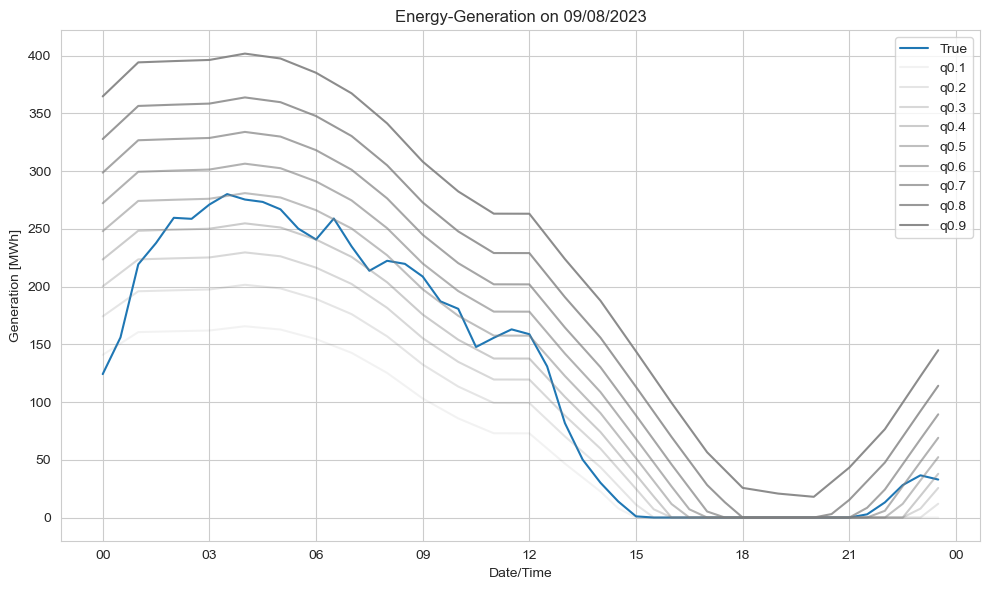

In [4]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=quantiles, year=2023, month=8, day=9)

### __Baseline solar energy forecast__

In [5]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from qr_model_solar\qr_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from qr_model_solar\qr_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_quantile_0.9.pkl
Using the loaded pretrained Quantile Regressor

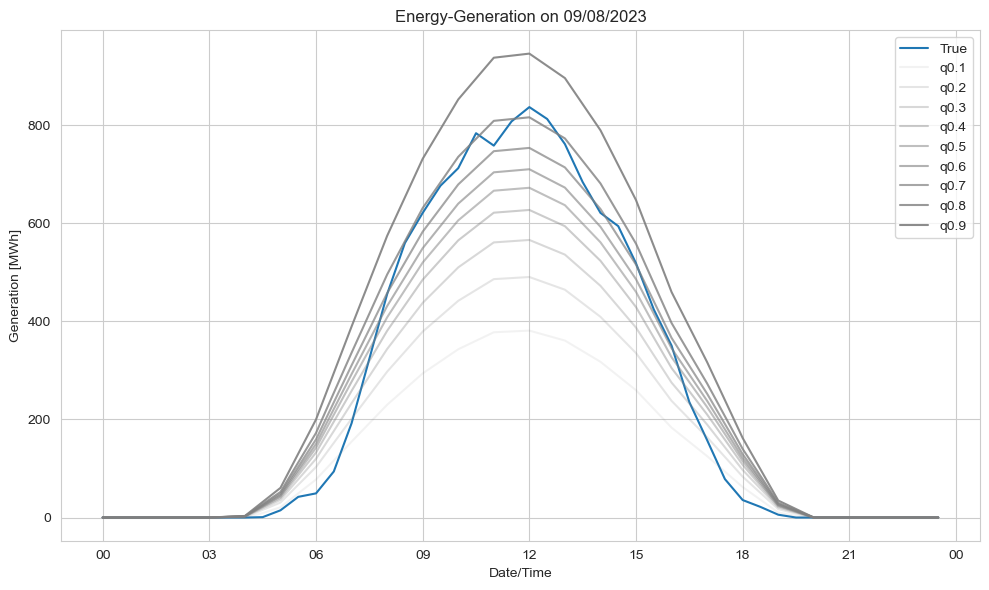

In [6]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=quantiles, year=2023, month=8, day=9)

### __LightGBM wind energy forecast__

In [124]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Using the loaded pr

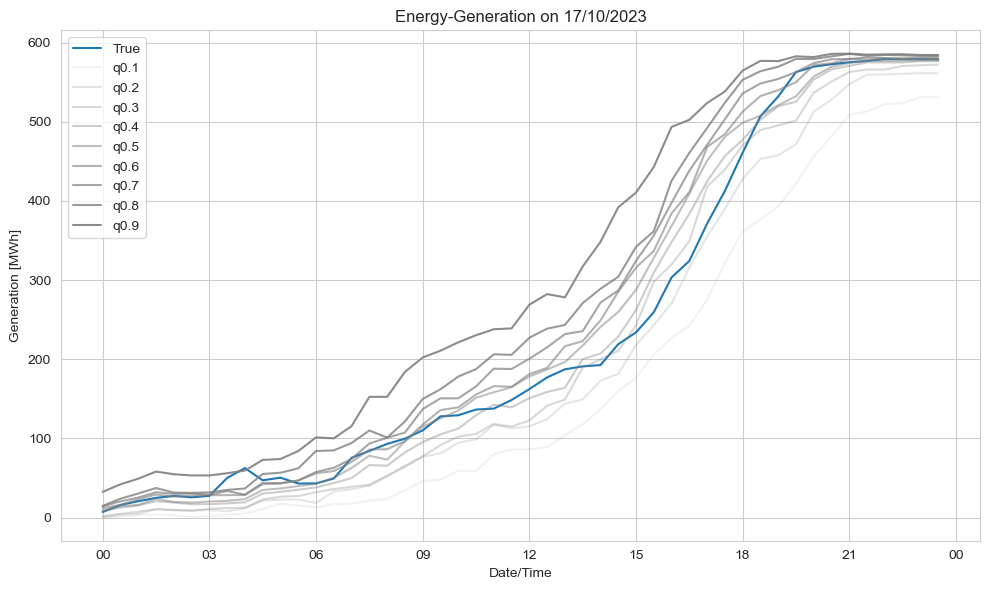

In [126]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, month=10, day=17)

### __LightGBM solar energy forecast__

In [9]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_solar\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_solar\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_solar\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_solar\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_solar\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_solar\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_solar\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_solar\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_solar\lgbm_model_quantile_0.9.pkl
Using the 

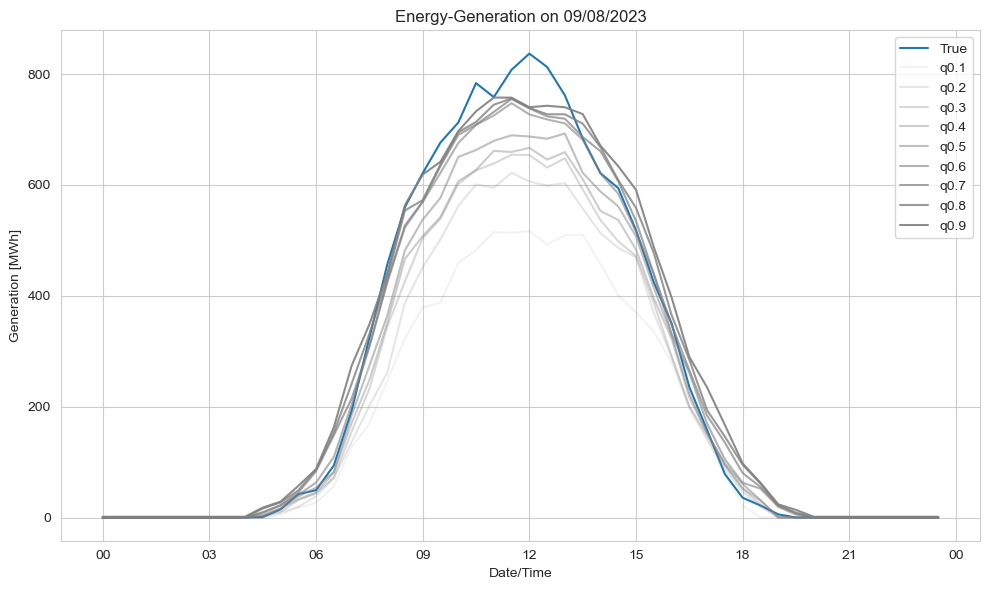

In [10]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=8, day=9)

### __Vergleich der Pinball Scores der Modelle__

In [12]:
performance_scores = {'Solarenergie' : [qr_model_solar.pinball_score(), lgbm_model_solar.pinball_score()],
                      'Windenergie' : [qr_model_wind.pinball_score(), lgbm_model_wind.pinball_score()]
                      }
performance_df = pd.DataFrame(performance_scores, index=["baseline", "LightGBM"])
performance_df

,Solarenergie,Windenergie
baseline,11.914653,31.795997
LightGBM,8.938359,21.476032


### __Modell Training all in one Modell__

In [14]:
import model_utils
import pandas as pd
import importlib
importlib.reload(model_utils)

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

columns_to_add = list()

for col in merged_hornsea.columns:
    if col not in merged_pes.columns:
        columns_to_add.append(col)

merged_all = merged_pes.merge(merged_hornsea[columns_to_add], left_index = True, right_index = True)
merged_all["energy"] = merged_all["Solar_MWh_credit"] + merged_all["Wind_MWh_credit"]
merged_all.drop(["Solar_MWh_credit", "Wind_MWh_credit"], axis = 1, inplace = True)

from Preprocessing import *
feature_engineerer_all = FeatureEngineerer(labels_to_remove=  ["energy"], columns_to_ohe = ['unavailabilityType', 'affectedUnit'], label = ["energy"])
feature_engineerer_all.perform_feature_engineering(merged_all, deployment = False, labels_to_remove=  ["energy"])

import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "lgbm_model_all"

lgbm_model = model_utils.LGBMRegressorModel(feature_engineerer_all, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_all\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_all\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_all\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_all\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_all\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_all\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_all\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_all\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_all\lgbm_model_quantile_0.9.pkl
Using the loaded pretrained 

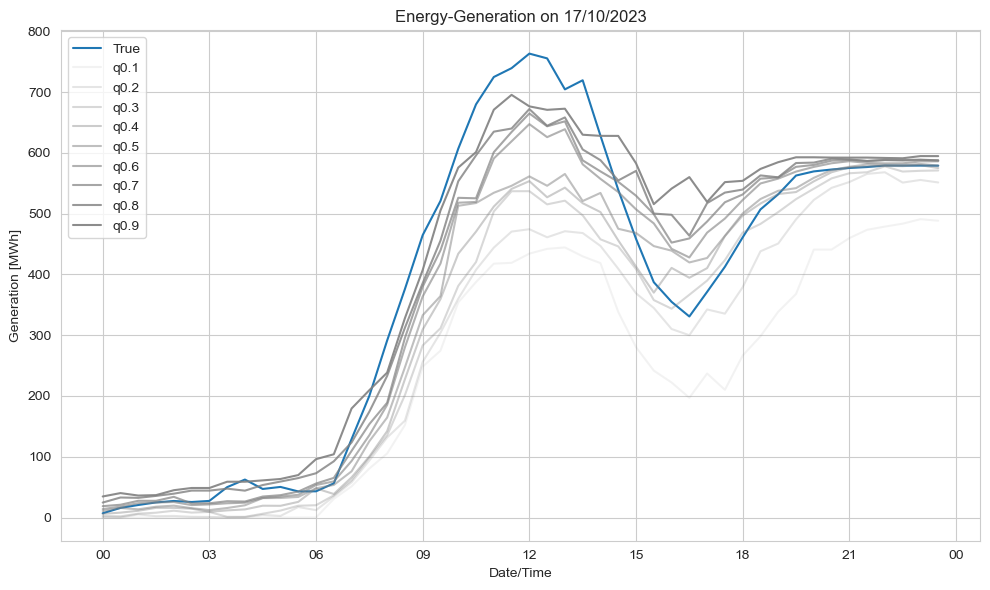

In [48]:
lgbm_model.plot_quantils(feature_engineerer_all.y_test.index, lgbm_model.q_predictions, quantiles, year=2023, month=10, day=17)

### __Combine Solar and Wind Modell for comparison__

In [72]:
solar_energy = lgbm_model_solar.q_predictions
wind_energy = lgbm_model_wind.q_predictions

combined_energy = {key: solar_energy[key] + wind_energy[key] for key in solar_energy}

model_utils.pinball_score(combined_energy, quantiles)

26.09143426874892

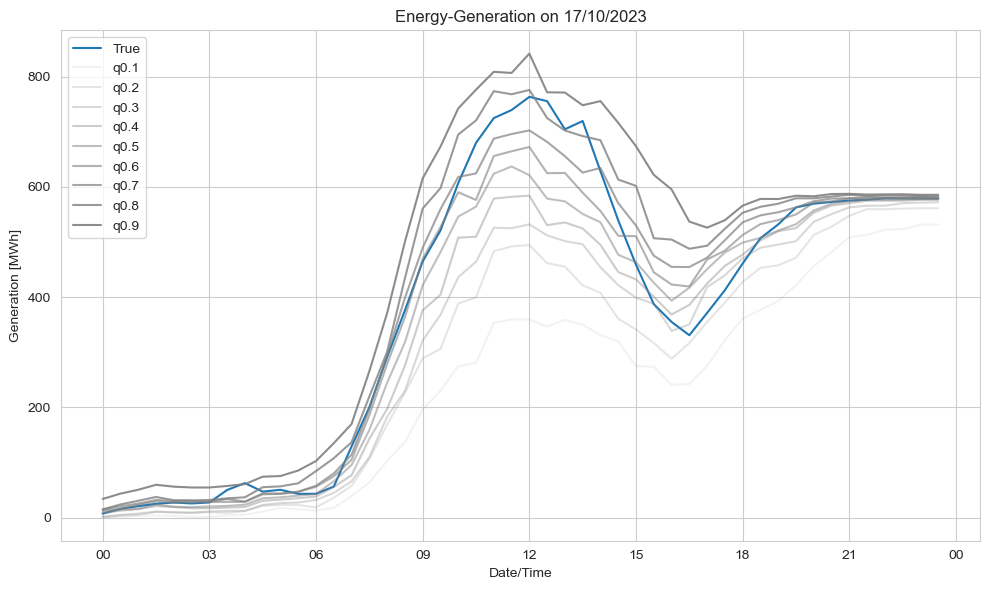

In [73]:
lgbm_model.plot_quantils(feature_engineerer_all.y_test.index, combined_energy, quantiles, year=2023, month=10, day=17)

In [74]:
performance_scores = {'Gesamt_Modell' : [lgbm_model.pinball_score()],
                      'Kombiniertes_Modell' : [model_utils.pinball_score(combined_energy, quantiles)]
                      }
performance_df = pd.DataFrame(performance_scores, index=["total_energy_without_HT"])
performance_df

,Gesamt_Modell,Kombiniertes_Modell
total_energy_without_HT,26.247761,26.091434


### __Use Hyperparametertuning for LightGBM__

__Wind__

In [132]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind_hyperparameter"

parameters = {
    'n_estimators': [200, 500, 1000],
    'boosting': ['gbdt', 'dart'],
    'max_depth': [2,5,10, 12],
    'learning_rate': [ 0.01, 0.1],
}

lgbm_model_wind_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind_hyperparameter.train_and_predict_hyperparametertuning(parameters)  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind_hyperparameter.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.8.pkl
Loaded p

In [133]:
# lgbm_model_wind_hyperparameter.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind_hyperparameter.q_predictions, quantiles, year=2023, month=10, day=17)

__solar__

In [ ]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar_hyperparameter"

parameters = {
    'n_estimators': [200, 500, 1000],
    'boosting': ['gbdt', 'dart'],
    'max_depth': [2,5,10, 12],
    'learning_rate': [ 0.01, 0.1],
}

lgbm_model_solar_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar_hyperparameter.train_and_predict_hyperparametertuning(parameters)  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar_hyperparameter.pinball_score()}")

In [ ]:
# lgbm_model_solar_hyperparameter.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar_hyperparameter.q_predictions, quantiles, year=2023, month=10, day=17)

__all in one__

In [ ]:
import model_utils
import pandas as pd
import importlib
importlib.reload(model_utils)

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

columns_to_add = list()

for col in merged_hornsea.columns:
    if col not in merged_pes.columns:
        columns_to_add.append(col)

merged_all = merged_pes.merge(merged_hornsea[columns_to_add], left_index = True, right_index = True)
merged_all["energy"] = merged_all["Solar_MWh_credit"] + merged_all["Wind_MWh_credit"]
merged_all.drop(["Solar_MWh_credit", "Wind_MWh_credit"], axis = 1, inplace = True)

from Preprocessing import *
feature_engineerer_all = FeatureEngineerer(labels_to_remove=  ["energy"], columns_to_ohe = ['unavailabilityType', 'affectedUnit'], label = ["energy"])
feature_engineerer_all.perform_feature_engineering(merged_all, deployment = False, labels_to_remove=  ["energy"])

import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

parameters = {
    'n_estimators': [200, 500, 1000],
    'boosting': ['gbdt', 'dart'],
    'max_depth': [2,5,10, 12],
    'learning_rate': [ 0.01, 0.1],
}

# Specify model save directory
model_save_dir_qr = "lgbm_model_all_hyperparameter"

lgbm_model_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_all, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_hyperparameter.train_and_predict_hyperparametertuning(parameters)  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_hyperparameter.pinball_score()}")